Notebook to apply various models to model the frequency of claims occurance

### Libraries used

In [457]:
import pandas as pd
pd.options.display.max_rows = 999
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.dummy import DummyClassifier

from sklearn.metrics import mean_squared_error, r2_score

import math

### Load Train and test data

In [2]:
# Train data
X_train_sc_mm = pd.read_csv('../Dataset/X_train_sc_mm.csv')
X_train_sc_st = pd.read_csv('../Dataset/X_train_sc_st.csv')
y_train = pd.read_csv('../Dataset/y_train.csv')

In [3]:
# Test data
X_test_sc_mm = pd.read_csv('../Dataset/X_test_sc_mm.csv')
X_test_sc_st = pd.read_csv('../Dataset/X_test_sc_st.csv')
y_test = pd.read_csv('../Dataset/y_test.csv')

### Baseline model

In [126]:
# get a base line model using DummyClassifer
dummy_clf = DummyClassifier(strategy = 'stratified', random_state = 42) # use the stratified strategy
dummy_clf.fit(X_train_sc_st, y_train)
y_train_dummyProba = dummy_clf.predict_proba(X_train_sc_st) # get the probability vectors
y_test_dummyProba = dummy_clf.predict_proba(X_test_sc_st)

In [130]:
# print the auc scores of the baseline dummy model
dummy_auc_train = roc_auc_score(y_train, y_train_dummyProba[:,1])
dummy_auc_test = roc_auc_score(y_test, y_test_dummyProba[:,1])
print('auc score on baseline model TRAIN: ', "{0:.2%}".format(dummy_auc_train))
print('auc score on baseline model TEST: ', "{0:.2%}".format(dummy_auc_test))

auc score on baseline model TRAIN:  50.04%
auc score on baseline model TEST:  49.69%


Conclusion:
- as can be seen, the Dummy model is presenting a random model giving auc of ~50% both on the train and the test set

### Logistic Regression Base

In [129]:
%%time
# perform grid_search for Logistic regression model
log_reg = LogisticRegression()

param_grid = { 'C' :[1e-3, 1e-1, 1, 1e1, 1e3],
                  'solver' : ['sag', 'newton-cholesky'] #using the solvers that should be the fastest on large datasets
                }

grid_search = GridSearchCV(estimator = log_reg, n_jobs = -1, param_grid = param_grid, cv = 4, scoring = 'roc_auc') # doing cross validation on train data set and using auc as a scoring metric
grid_search.fit(X_train_sc_st, y_train.values.ravel())
grid_search.best_params_

CPU times: total: 46.9 s
Wall time: 4min 8s


{'C': 0.1, 'solver': 'sag'}

In [137]:
%%time
#fit best model and apply to training and test data
log_reg_best = grid_search.best_params_
#log_best = LogisticRegression(n_jobs = -1, C= 1, solver = 'sag')
log_best = LogisticRegression(n_jobs = -1, **log_reg_best)

log_best.fit(X_train_sc_st, y_train.values.ravel()) # fit the model to train data based on best hyperparameters

y_train_logregProba = log_best.predict_proba(X_train_sc_st)
y_test_logregProba = log_best.predict_proba(X_test_sc_st)

CPU times: total: 53.2 s
Wall time: 53.8 s


In [138]:
# print the auc scores of the baseline dummy model
logreg_auc_train = roc_auc_score(y_train, y_train_logregProba[:,1])
logreg_auc_test = roc_auc_score(y_test, y_test_logregProba[:,1])
print('auc score on baseline model TRAIN: ', "{0:.2%}".format(logreg_auc_train))
print('auc score on baseline model TEST: ', "{0:.2%}".format(logreg_auc_test))

auc score on baseline model TRAIN:  63.67%
auc score on baseline model TEST:  63.41%


Conclusion:
- Logistic Regression is showing a better fit than the random baseline model
- scores on train and test data are quite similar so no over- or underfit on the data is expected
- still the resulting scores are not overwhelming, i.e. might still be improved

### Random Forest - GridSearch

In [14]:
%%time
# Finding the optimal decision tree classifier
rf_class = RandomForestClassifier(random_state = 42)

#define the grid 
rf_grid = {'max_depth' : [20,25,30],#,13,15,20
                  'min_samples_split' : [2,3,5],#,7,10,13
                  'min_samples_leaf' : [2,3,5]#,5,7
                }                                  
                                  
rf_search = GridSearchCV(estimator = rf_class, n_jobs = -1, param_grid = rf_grid, cv = 4, scoring = 'roc_auc') # use roc_auc as the metric to optimise and 4-fold cross validation
rf_search.fit(X_train_sc_st, y_train.values.ravel())

# get bets parameters
rfgrid_best_param = rf_search.best_params_
rfgrid_best_param

CPU times: total: 1min 48s
Wall time: 1h 21min 13s


{'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [139]:
%%time
# Fitting the model with the best parameters
rf_best = RandomForestClassifier(n_jobs = -1, random_state = 42, **rfgrid_best_param)
#rf_best = RandomForestClassifier(n_jobs = -1, random_state = 42, max_depth= 20, min_samples_leaf= 5, min_samples_split= 3

rf_best.fit(X_train_sc_st, y_train.values.ravel()) # fit best model on train data

y_train_rfgsProba = rf_best.predict_proba(X_train_sc_st) # apply model
y_test_rfgsProba = rf_best.predict_proba(X_test_sc_st)

CPU times: total: 4min 2s
Wall time: 1min 6s


In [354]:
# print the auc scores of the baseline dummy model
rfgs_auc_train = roc_auc_score(y_train, y_train_rfgsProba[:,1])
rfgs_auc_test = roc_auc_score(y_test, y_test_rfgsProba[:,1])
print('auc score on Random Forest model TRAIN: ', "{0:.2%}".format(rfgs_auc_train))
print('auc score on Random Rorest model TEST: ', "{0:.2%}".format(rfgs_auc_test))

auc score on Random Forest model TRAIN:  81.63%
auc score on Random Rorest model TEST:  69.77%


Conclusion:
- The random forest shows a better score then the logistic regression
- Although crossvalidation was performed there seems to be a bit of an overfit on the train data
- -> threfore grid search is performed a 2nd time but with slightly changed parameters to avoid overfit on train data

In [198]:
%%time
# Finding the optimal decision tree classifier
rf_class = RandomForestClassifier(random_state = 42)

#define the grid 
rf_grid = {'max_depth' : [10, 15],#,13,15,20
                  'min_samples_split' : [5,7],#,7,10,13
                  'min_samples_leaf' : [5,7]#,5,7
                }                                  
                                  
rf_search = GridSearchCV(estimator = rf_class, n_jobs = -1, param_grid = rf_grid, cv = 4, scoring = 'roc_auc') # use roc_auc as the metric to optimise and 4-fold cross validation
rf_search.fit(X_train_sc_st, y_train.values.ravel())

# get bets parameters
rfgrid_best_param = rf_search.best_params_
rfgrid_best_param

CPU times: total: 1min 32s
Wall time: 16min 40s


{'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5}

In [199]:
%%time
# Fitting the model with the best parameters
rf_best = RandomForestClassifier(n_jobs = -1, random_state = 42, **rfgrid_best_param)
#rf_best = RandomForestClassifier(n_jobs = -1, random_state = 42, max_depth= 20, min_samples_leaf= 5, min_samples_split= 3

rf_best.fit(X_train_sc_st, y_train.values.ravel()) # fit best model on train data

y_train_rfgsProba = rf_best.predict_proba(X_train_sc_st) # apply model
y_test_rfgsProba = rf_best.predict_proba(X_test_sc_st)

CPU times: total: 3min 16s
Wall time: 50.8 s


In [355]:
# print the auc scores of the Random Forest model, hyperparameters optimised by grid search
rfgs_auc_train = roc_auc_score(y_train, y_train_rfgsProba[:,1])
rfgs_auc_test = roc_auc_score(y_test, y_test_rfgsProba[:,1])
print('auc score on Random Forest TRAIN: ', "{0:.2%}".format(rfgs_auc_train))
print('auc score on Random Forest TEST: ', "{0:.2%}".format(rfgs_auc_test))

auc score on Random Forest TRAIN:  81.63%
auc score on Random Forest TEST:  69.77%


Conclusion:
- Still there is a bit of an overfit, but on an acceptable level now
- Still some more hyperparameter tuning could be made to even reduce the slight overfit and probably even find a model that better fits on the test data

### Boosting - AdaBoost

In [149]:
%%time
# Finding the optimal decision tree classifier
ab_class = AdaBoostClassifier(random_state = 42)

#define the grid for the AdaBoost Classifier
ab_grid = {'n_estimators' : [50,100,200],#
                  'learning_rate' : [0.2, 0.5, 1]#
          }
                                  
ab_search = GridSearchCV(estimator = ab_class, n_jobs = -1, param_grid = ab_grid, cv = 4, scoring = 'roc_auc') # use roc_auc as the metric to optimise and 4-fold cross validation
ab_search.fit(X_train_sc_st, y_train.values.ravel())

# get bets parameters
abgrid_best_param = ab_search.best_params_
abgrid_best_param

CPU times: total: 2min 30s
Wall time: 21min 12s


{'learning_rate': 1, 'n_estimators': 200}

In [150]:
%%time
# Fitting the model with the best parameters
ab_best = AdaBoostClassifier(random_state = 42, **abgrid_best_param)

ab_best.fit(X_train_sc_st, y_train.values.ravel()) # fit best model on train data

y_train_abProba = ab_best.predict_proba(X_train_sc_st) # apply model
y_test_abProba = ab_best.predict_proba(X_test_sc_st)

CPU times: total: 3min 1s
Wall time: 3min 1s


In [356]:
# print the auc scores of the Ada Boost model, hyperparameters optimised by grid search
ab_auc_train = roc_auc_score(y_train, y_train_abProba[:,1])
ab_auc_test = roc_auc_score(y_test, y_test_abProba[:,1])
print('auc score on AdaBoost model TRAIN: ', "{0:.2%}".format(ab_auc_train))
print('auc score on AdaBoost model TEST: ', "{0:.2%}".format(ab_auc_test))

auc score on AdaBoost model TRAIN:  68.35%
auc score on AdaBoost model TEST:  67.59%


Conclusion:
- acceptable results and not overvit
- -> doing another try with higher number of estimators, using defaul learning rate

In [194]:
%%time
# Finding the optimal decision tree classifier
ab_class = AdaBoostClassifier(random_state = 42)

#define the grid for the AdaBoost Classifier
ab_grid = {'n_estimators' : [300,500,700]# only focusing on nr. of estimators this time
          }
                                  
ab_search = GridSearchCV(estimator = ab_class, n_jobs = -1, param_grid = ab_grid, cv = 4, scoring = 'roc_auc') # use roc_auc as the metric to optimise and 4-fold cross validation
ab_search.fit(X_train_sc_st, y_train.values.ravel())

# get bets parameters
abgrid_best_param = ab_search.best_params_
abgrid_best_param

CPU times: total: 8min 50s
Wall time: 35min 37s


{'n_estimators': 700}

In [195]:
%%time
# Fitting the model with the best parameters
ab_best = AdaBoostClassifier(random_state = 42, **abgrid_best_param)

ab_best.fit(X_train_sc_st, y_train.values.ravel()) # fit best model on train data

y_train_abProba = ab_best.predict_proba(X_train_sc_st) # apply model
y_test_abProba = ab_best.predict_proba(X_test_sc_st)

CPU times: total: 10min 42s
Wall time: 10min 43s


In [357]:
# print the auc scores of the Ada Boost model, hyperparameters optimised by grid search
ab_auc_train = roc_auc_score(y_train, y_train_abProba[:,1])
ab_auc_test = roc_auc_score(y_test, y_test_abProba[:,1])
print('auc score on  AdaBoost model TRAIN: ', "{0:.2%}".format(ab_auc_train))
print('auc score on  AdaBoost model TEST: ', "{0:.2%}".format(ab_auc_test))

auc score on  AdaBoost model TRAIN:  68.35%
auc score on  AdaBoost model TEST:  67.59%


Conclusion:
- going for higher estimates slightly improved the fit
- we could now of course go for even higher number of estimates, but that is computationally quite expensive
- -> we make a stop here

### Decision Tree Applying Tree Pruning

using another version of Decision Trees: 
- Firstly developing the full Decision tree
- than pruning it using Minimal Cost Complexity Pruning
- source: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py

In [153]:
%%time
# Defining and fitting the tree
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train_sc_st, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

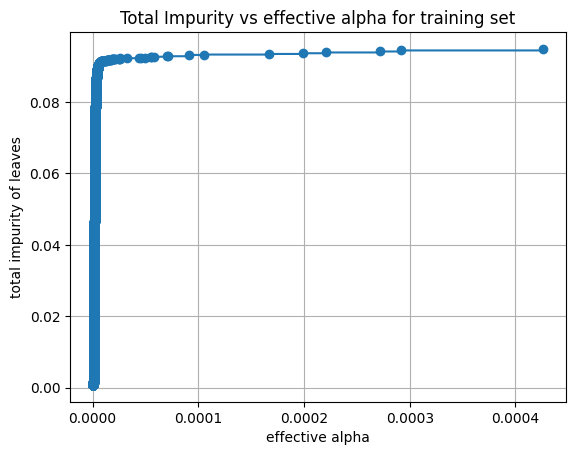

In [160]:
# plot impurities and alphas
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.grid()
plt.show()

In [171]:
# Analysing ccp_alpha and impurities
print('length of vector: ', len(ccp_alphas))
print('nr of alphas with impurity > 0.06: ', len(ccp_alphas[impurities > 0.06]))
print('nr of alphas with impurity > 0.09: ', len(ccp_alphas[impurities > 0.09]))

length of vector:  11857
nr of alphas with impurity > 0.06:  2612
nr of alphas with impurity > 0.09:  144


Conclusion:
- overall lenght of ccp_alphas vector is too long to caldualte the decision tree for every alpha
- therefore ccp_alphas is limited to only those that have impurity greater than 6% and then taking only every 10th alpha

In [172]:
# downselecting ccp alphas for a reasonable run-time
ccp_alphas = ccp_alphas[impurities > 0.06][::10]
len(ccp_alphas)

262

In [173]:
%%time
# train decision tree using the effective alphas, last value in ccp-alphas prunes the tree
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train_sc_st, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 3 with ccp_alpha: 0.00042653229291839123


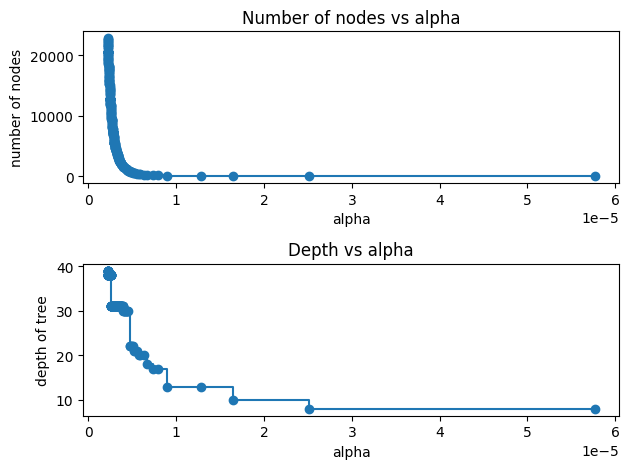

In [174]:
# plot nodes and depth vs. alphas
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

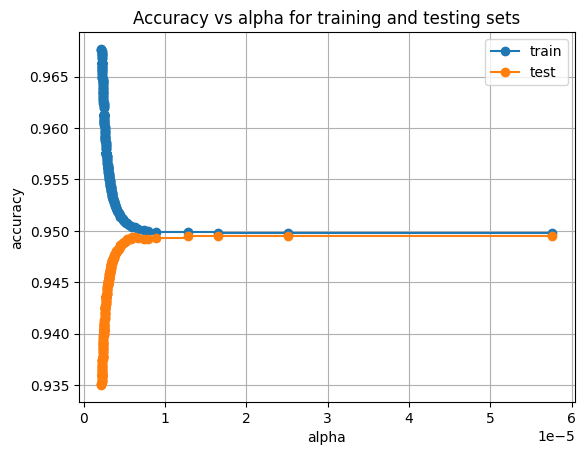

CPU times: total: 1min 2s
Wall time: 1min 2s


In [209]:
%%time
# show accuaracy of certain alpha parameters for train and test data
train_scores = [clf.score(X_train_sc_st, y_train) for clf in clfs]
test_scores = [clf.score(X_test_sc_st, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.grid()
plt.show()

Conclusion:
- at a certain level of alpha the scores are coming quite closely together -> this seems to be a good alpha parameter
- the curve of the test scores seems to be a bit humped -> i.e. accuracy is going up, but seems to decline at a certain alpha level again
- -> taking the maximum alpha parameter for the final parameterisation

In [255]:
%%time
# Train final tree with the selected ccp-alpha parameter
final_clf = DecisionTreeClassifier(random_state=42, ccp_alpha = ccp_alphas[np.argmax(test_scores)]) # taking alpha parameter with highest score
final_clf.fit(X_train_sc_st, y_train)

y_train_clfProba = final_clf.predict_proba(X_train_sc_st) # apply model
y_test_clfProba = final_clf.predict_proba(X_test_sc_st)

CPU times: total: 12.7 s
Wall time: 12.7 s


In [359]:
# print the auc scores of the pruned Desision tree model
clf_auc_train = roc_auc_score(y_train, y_train_clfProba[:,1])
clf_auc_test = roc_auc_score(y_test, y_test_clfProba[:,1])
print('auc score on Decision Tree model TRAIN: ', "{0:.2%}".format(clf_auc_train))
print('auc score on Decision Tree model TEST: ', "{0:.2%}".format(clf_auc_test))

auc score on Decision Tree model TRAIN:  67.96%
auc score on Decision Tree model TEST:  67.02%


### Models overview and final selection

In [257]:
# Summarising all results in one DataFrame
overall_model_results = pd.DataFrame([['Baseline', dummy_auc_train, dummy_auc_test], ['Logistic Regression', logreg_auc_train, logreg_auc_test],
                                      ['Random Forest', rfgs_auc_train, rfgs_auc_test], ['AdaBoost', ab_auc_train, ab_auc_test], 
                                      ['Decision Tree pruned', clf_auc_train, clf_auc_test]], columns = ['Model', 'AUC_TRAIN', 'AUC_TEST']
                                        )

display(overall_model_results)

,Model,AUC_TRAIN,AUC_TEST
0,Baseline,0.500446,0.496922
1,Logistic Regression,0.636728,0.634127
2,Random Forest,0.816322,0.697680
3,AdaBoost,0.683520,0.675927
4,Decision Tree pruned,0.679635,0.670156


Final Conclusion:
- Basically the model based on the Random Forest finally shows the highest score on the test data -> therefore it is chosen as the final model
- it is followed quite closely by the AdaBoost Model and the pruned Decision Tree model
- Potentially also some model stacking can be tried out, but it is left out here due to the given time constraints
- the slight overfit in the Random Forest on the train data is still acceptable, but should be constantly monitored

### Best Model fit and analysis

#### Derive the final model on TEST data

In [260]:
%%time
# check the optimal number of estimators of the random forest model

n_estimators = [200, 300, 500] # nr of estimators to try
rf_train_scores = [rfgs_auc_train] # add values with n_estimators = 100 for comparison
rf_test_scores = [rfgs_auc_test]

for n in n_estimators:
    reg_forest = RandomForestClassifier(n_jobs = -1, n_estimators = n, **rfgrid_best_param) # instantinate the model object with the best parameters and the given Nr of estimators
    reg_forest.fit(X_train_sc_st, y_train)
    
    y_tr_rfProba = reg_forest.predict_proba(X_train_sc_st)
    y_te_rfProba = reg_forest.predict_proba(X_test_sc_st)
    
    rf_train_scores.append(roc_auc_score(y_train, y_tr_rfProba[:,1]))
    rf_test_scores.append(roc_auc_score(y_test, y_te_rfProba[:,1]))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11976\3149660302.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg_forest.fit(X_train_sc_st, y_train)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11976\3149660302.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg_forest.fit(X_train_sc_st, y_train)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11976\3149660302.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg_forest.fit(X_train_sc_st, y_train)


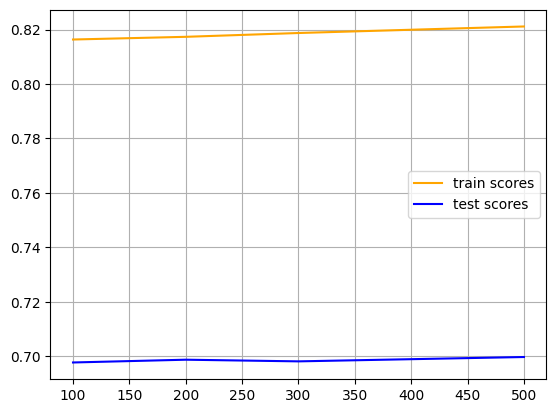

In [276]:
# plot the resulting  vectors
n_ests = np.concatenate(( [100], np.array(n_estimators)))

sns.lineplot(x = n_ests, y = rf_train_scores, color = 'orange', label = 'train scores')
sns.lineplot(x = n_ests, y = rf_test_scores, color = 'blue', label = 'test scores')
plt.grid()
plt.show()

Conclusion:
- developing more trees does not really bring added value here, but just needs more computation ressources
- even more the fit on the train data seems to improve faster then on the test data, thus increasing the overfit
- -> stay with n=100 as the final number of estimators

In [279]:
# plot the resulting ROC curve on the test data for the final model, based on TEST data

fpr, tpr, thresholds = roc_curve(y_test, y_test_rfgsProba[:,1]) # calculate False positive, true positive rate for plotting

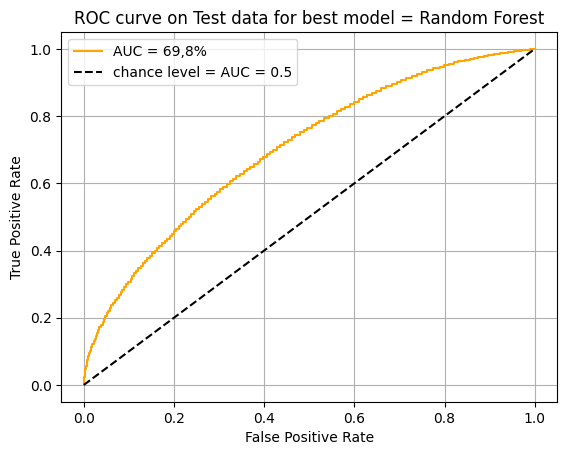

In [292]:
# Plot the ROC curve
x = fpr[::100] # reduce values so that the plot can be created
y = tpr[::100]
sns.lineplot(x = x,y = y, drawstyle='steps-pre', color = 'orange', label = 'AUC = 69,8%' )
sns.lineplot(x = [0,1], y = [0,1], linestyle = '--', color = 'black', label = 'chance level = AUC = 0.5')
plt.title('ROC curve on Test data for best model = Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

In [306]:
len(y_test), y_test.sum()

(135603,
 Claim    6846
 dtype: int64)

In [325]:
# checking for the thresold that roughly gives the same nr of claims as in the test data (done manually instead os solved via a function) -> i:e. keep the observed frequency of claims
probs =  y_test_rfgsProba[:,1]
len(probs[probs >= 0.101203])

6843

In [329]:
# predict labels given the found threshold
asign_poslabels = lambda x: 0 if x < 0.101203 else 1 # probabilites greater or equal to the threshold are labelled  as 1
y_pred = np.array(list(map(asign_poslabels, probs)))
y_pred.sum()

6843

              precision    recall  f1-score   support

           0       0.96      0.96      0.96    128757
           1       0.18      0.18      0.18      6846

    accuracy                           0.92    135603
   macro avg       0.57      0.57      0.57    135603
weighted avg       0.92      0.92      0.92    135603



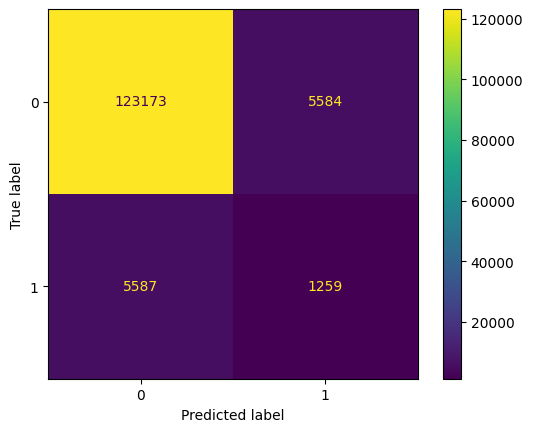

In [332]:
# show confusion matrix and classification report on the test data
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test.values.ravel(), y_pred), display_labels=rf_best.classes_)
disp.plot()
print(classification_report(y_test.values.ravel(), y_pred))

#### train the final model on ALL data 

In [337]:
# prepare data
X_total = pd.concat([X_train_sc_st, X_test_sc_st], ignore_index = True)
X_total.shape

(678013, 42)

In [387]:
# prepare target labels
y_total = pd.concat([y_train, y_test], ignore_index = True)
y_total.shape

(678013, 1)

In [348]:
# fit the final model with the given hyperparameters on the total data set
forest_final = RandomForestClassifier(n_jobs = -1, n_estimators = 100, **rfgrid_best_param)
                                      
forest_final.fit(X_total, y_total.values.ravel())
                                      
pred_proba_final = forest_final.predict_proba(X_total)

In [360]:
#auc on total data set
final_auc_total = roc_auc_score(y_total, pred_proba_final[:,1])
print('auc score on Final model - ALL Data: ', "{0:.2%}".format(final_auc_total))

auc score on Final model - ALL Data:  80.60%


In [350]:
# plot the resulting ROC curve on the test data for the final model, based on ALL data

fpr, tpr, thresholds = roc_curve(y_total, pred_proba_final[:,1]) # calculate False positive, true positive rate for plotting

In [351]:
len(fpr)

86983

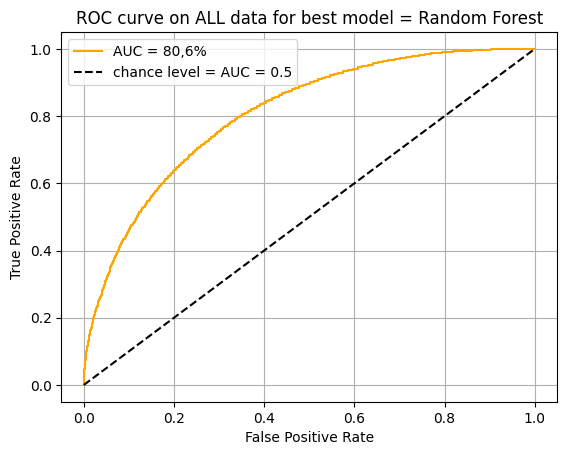

In [362]:
# Plot the ROC curve for ALL data
x = fpr[::400] # reduce values so that the plot can be created
y = tpr[::400]
sns.lineplot(x = x,y = y, drawstyle='steps-pre', color = 'orange', label = 'AUC = 80,6%' )
sns.lineplot(x = [0,1], y = [0,1], linestyle = '--', color = 'black', label = 'chance level = AUC = 0.5')
plt.title('ROC curve on ALL data for best model = Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

In [363]:
# total claims
len(y_total), y_total.sum()

(678013,
 Claim    34060
 dtype: int64)

In [383]:
# checking for the thresold that roughly gives the same nr of claims as on all data (done manually instead os solved via a function) -> i:e. keep the observed frequency of claims
probs =  pred_proba_final[:,1]
len(probs[probs >= 0.10274])

34062

In [385]:
asign_poslabels = lambda x: 0 if x <  0.10274 else 1 # probabilites greater or equal to the threshold are labelled  as 1
y_pred = np.array(list(map(asign_poslabels, probs)))
y_pred.sum()

34062

              precision    recall  f1-score   support

           0       0.96      0.96      0.96    643953
           1       0.27      0.27      0.27     34060

    accuracy                           0.93    678013
   macro avg       0.61      0.61      0.61    678013
weighted avg       0.93      0.93      0.93    678013



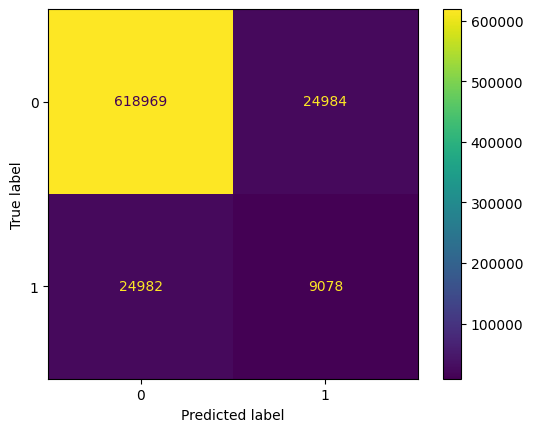

In [389]:
# show confusion matrix and classification report on the test data
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_total.values.ravel(), y_pred), display_labels=rf_best.classes_)
disp.plot()
print(classification_report(y_total.values.ravel(), y_pred))

Finding:
- Same as on the test data, there is quite a huge number of False positives and False negatives also. As can be seen also by the rather low precission and recall for the positive label.

#### Analyse the feature importance

In [454]:
# derive scikit-learn Feature importance
feature_importance = forest_final.feature_importances_
len(feature_importance)

42

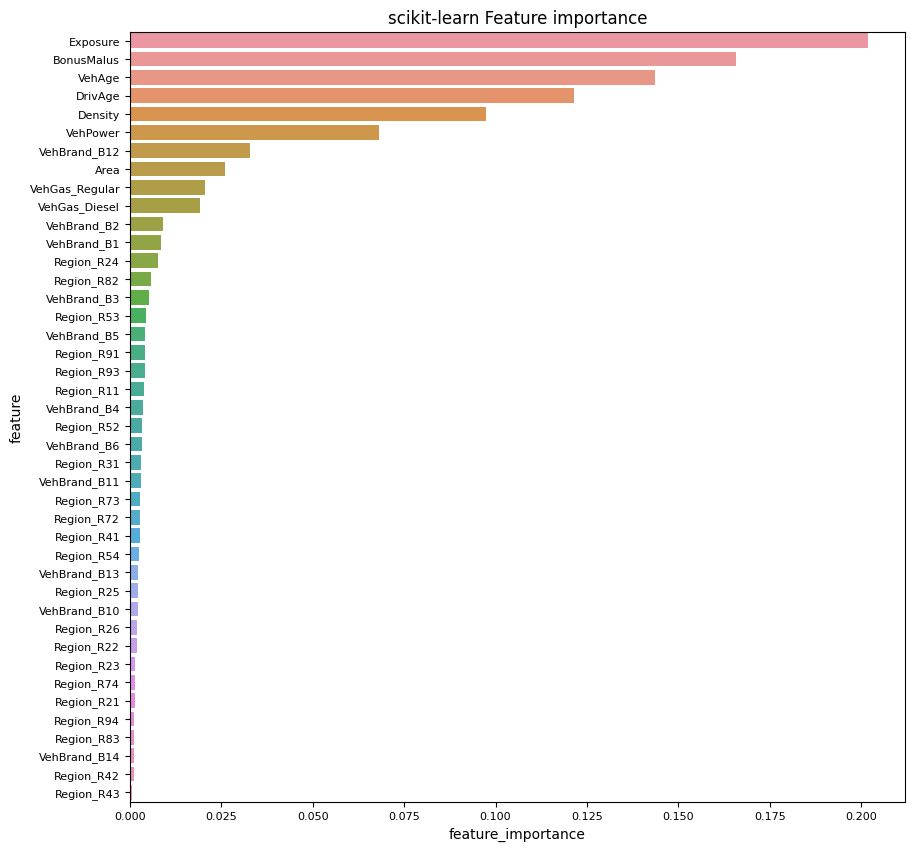

In [452]:
fi_df = pd.DataFrame([feature_importance, X_train_sc_st])
fi_df = fi_df.T
fi_df.columns = ['feature_importance', 'feature']
fi_df = fi_df.sort_values(by = 'feature_importance', ascending = False)

plt.figure(figsize=(10,10))
sns.barplot(x = fi_df['feature_importance'], y= fi_df['feature'], orient = 'h')
plt.title('scikit-learn Feature importance')
plt.show()

Conclusion:
- the numerical feature seem to have a higher importance than the categorical ones
- it is quite intuitive the Expore is having a high importance to the number of claims
- also Bonus Malus which is presenting some kind of risk scoring is a strong feature
- as a follow up also shap or lime libraries can be used to get even more details, like correlation of features with the target variable

#### checking resulting claims frequency

In [397]:
# get original data
claims_data = pd.read_csv('../Dataset/FreMTPL2freq.csv')
claims_data['Claim'] = claims_data['ClaimNb'].apply(lambda x: 1 if x >=1 else 0)
claims_data.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Claim
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,1
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82,1
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22,1
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72,1
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72,1


In [404]:
# perform train test split
# train-test split should be applied before the feature transformation
X_train, X_test, y_train, y_test = train_test_split(claims_data, claims_data[['Claim']] , test_size=0.2, random_state=42)
y_train.head()

,Claim
406477,1
393150,0
252885,0
260652,0
661256,0


In [409]:
# concatenate the full data set
X_full = pd.concat([X_train, X_test], ignore_index = True)

# get the predicted values
X_full['Claim_pred'] = y_pred

X_full.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Claim,Claim_pred
0,3099378.0,1,1.00,B,6,5,59,50,B2,Diesel,96,R72,1,0
1,3068220.0,0,1.00,C,10,11,61,50,B3,Regular,111,R91,0,0
2,2107013.0,0,1.00,A,7,4,42,50,B1,Diesel,19,R72,0,0
3,2121304.0,0,1.00,A,6,4,52,50,B2,Diesel,16,R82,0,0
4,6084903.0,0,0.28,D,5,3,71,50,B12,Regular,538,R53,0,0


In [418]:
# define the columns that should be plotted
plot_cols = ['Area', 'VehPower', 'VehAge', 'VehBrand', 'VehGas', 'Region']

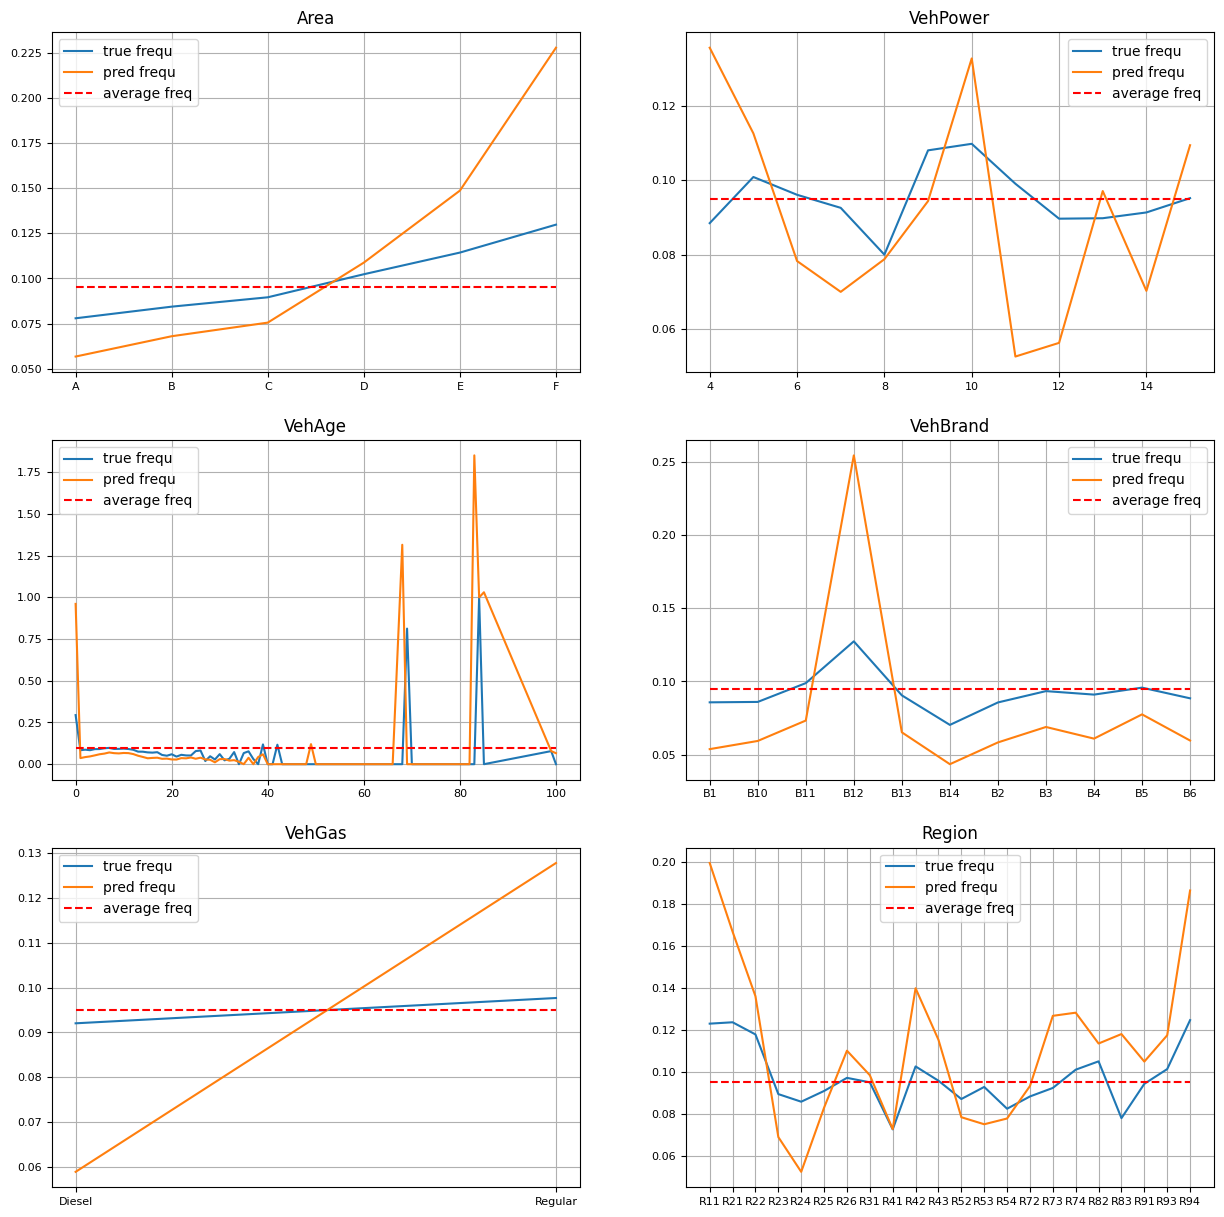

In [426]:
#  print details for frequency per feature (categorical and numerical with limited nr. of classes)
Totfreq_weighted = claims_data['Claim'].sum()/claims_data['Exposure'].sum()

n_cols = 2 # set number of columns in subplots
n_rows = math.ceil(len(plot_cols) / n_cols) # calculate the respective nr. of rows needed

plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 

fig, axs = plt.subplots(n_rows, n_cols, figsize = (15,15))
#axs2 = axs

for counter in range (len(plot_cols)): # loop over all columns
    col = plot_cols[counter]
    an_table = X_full.groupby(by = col).agg(true_claims = ('Claim', 'sum'), pred_claims = ('Claim_pred', 'sum'), s_exp = ('Exposure', 'sum')).reset_index()
    an_table['true_freq'] = an_table['true_claims'] / an_table['s_exp']
    an_table['pred_freq'] = an_table['pred_claims'] / an_table['s_exp']
    
    #display(an_table)
    r = counter // n_cols
    c = counter % n_cols
    #print(counter, r,c)
    axs[r,c].plot(an_table[col], an_table['true_freq'], label = 'true frequ') # plot specific requency as bar plot
    axs[r,c].plot(an_table[col], an_table['pred_freq'], label = 'pred frequ') # plot specific requency as bar plot
    axs[r,c].plot(an_table[col], np.ones(len(an_table[col])) * Totfreq_weighted, color = 'red', label= 'average freq', linestyle = '--')
    axs[r,c].set_title(str(col))
    axs[r,c].grid()
    axs[r,c].legend()
    
    #axs2[r,c] = axs[r,c].twinx()
    #axs2[r,c].bar(an_table[col], an_table['pred_freq'], color = 'cyan', label = 'Total Exposure') # plot volume on secondary axis
    #axs2[r,c].legend()
    
plt.show()

Conclusion:
- the model tends to over-punish a bit those classes that already show a high frequency in reality, 
- e.g. area F of non-diesel drivers would have a higher risk scores whereas other classes get a lower expected frequency
- questionable how e.g. such a behaviour can be accepted when pricing risks
- as an alternative results can be compared to a classical GLM also which might show smoother values